## 1. Importing Libraries

In [ ]:
import pandas as pd          ### For handling dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast       ### DistilBERT Tokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW    ### Optimizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.plotting.backend = "plotly"

## 2. Preparing dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/content/sample_data/Tweets.csv')

# Map sentiments to numerical labels
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df = df.rename(columns={'airline_sentiment':'label'})

df['label'] = df['label'].map(sentiment_mapping)


df = df[['text','label']]

In [ ]:
df.head()

,text,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [ ]:
# Display statistics about the dataset
print("\nDataset Statistics:")
print(df['label'].value_counts())


Dataset Statistics:
label
0    9746
1    3099
2    2363
Name: count, dtype: int64


## 3. EDA

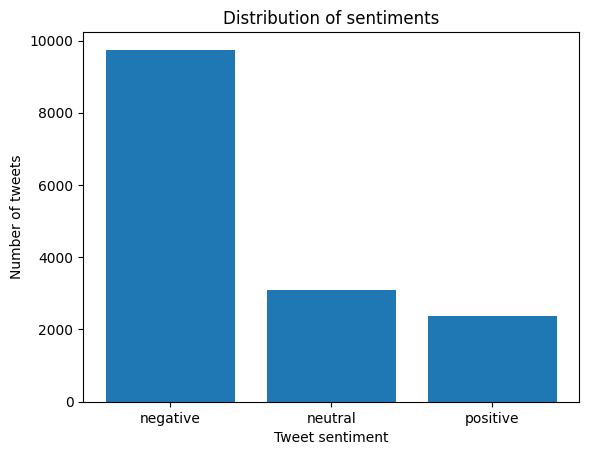

In [ ]:
# The distribution of sentiments

import numpy as np
x = np.array(["negative", "neutral", "positive"])
y = np.array([9746, 3099, 2363])
# y = df.groupby('label').count()
plt.bar(x,y)
plt.title("Distribution of sentiments")
plt.xlabel("Tweet sentiment")
plt.ylabel("Number of tweets")
plt.savefig('/content/sample_data/sentiment.png')
plt.show()

# .plot(kind='bar')
# plt.xlabel("X label")
# plt.ylabel("Y label")

In [ ]:
# Calculate tweet lengths
df = df[df['text'].notnull()]
tweet_len = pd.Series([len(tweet.split()) for tweet in df['text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

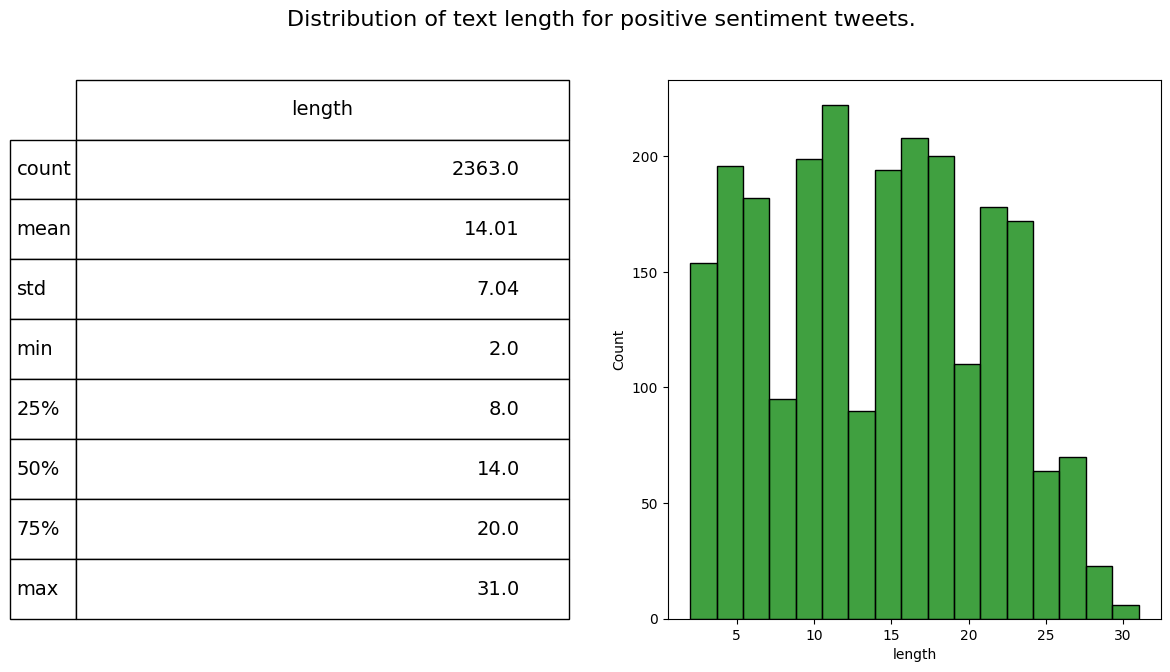

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['label']==2]['length'], ax=ax1,color='green')
describe = df.length[df.label ==2].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

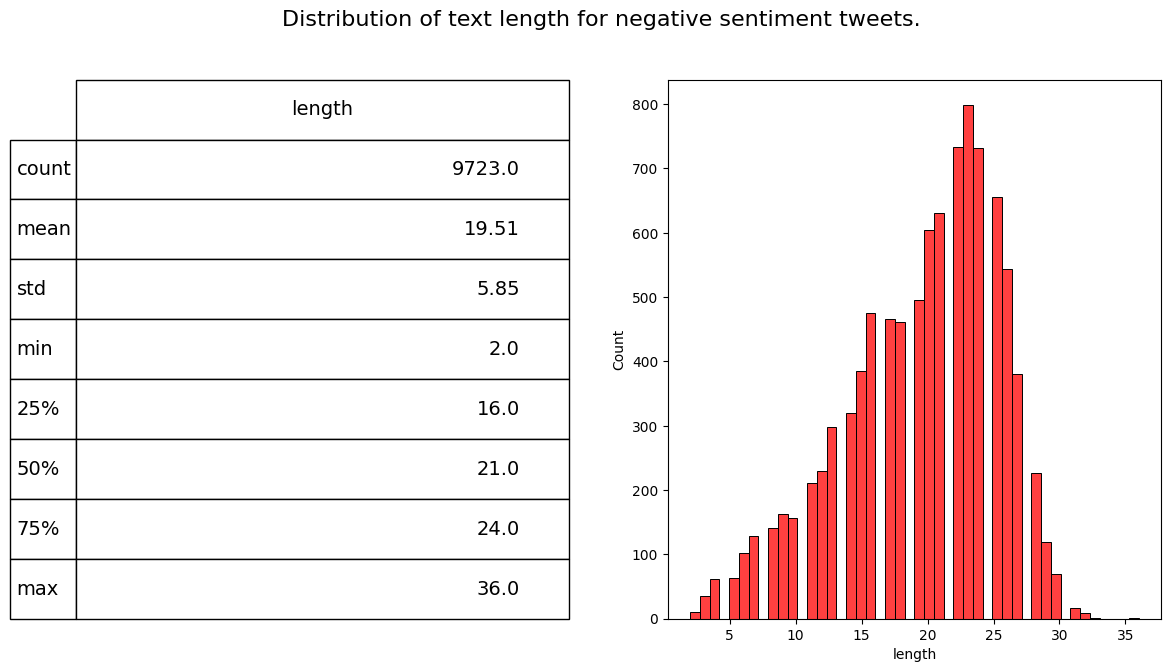

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['label']==0]['length'], ax=ax1,color='red')
describe = df.length[df.label == 0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

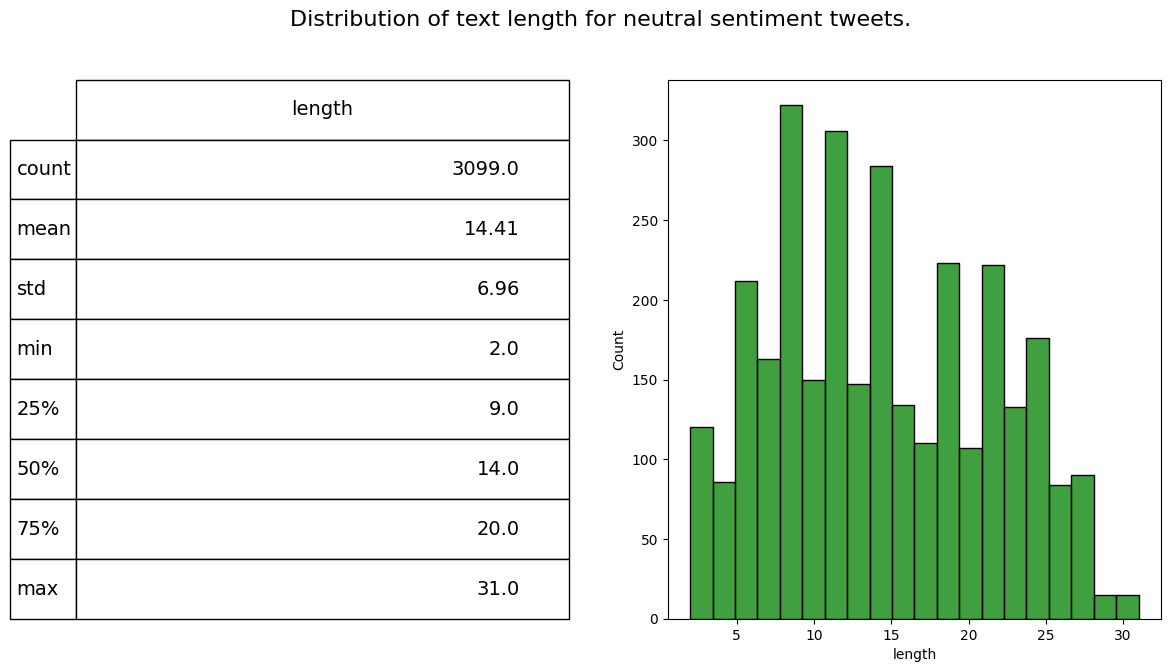

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['label']== 1]['length'], ax=ax1,color='green')
describe = df.length[df.label == 1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment tweets.', fontsize=16)

plt.show()

In [ ]:
import plotly.express as px
fig = px.pie(df, names='label', title ='Pie chart of different sentiments of tweets')
fig.show()

In [ ]:
df.drop(['length'], axis=1, inplace=True)

## 4. Creating Dataloader

- To load data in batches while fine tuning so that to avoid memory bottleneck.

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataset = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 0]  # Assuming reviewText is the first column
        sentiment = self.dataset.iloc[idx, 1]  # Assuming sentiment is the second column

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,  # Add [CLS] token at the start for classification
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'review_text': review_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(), # this is NOT self-attention!
          'labels': torch.tensor(sentiment, dtype=torch.long)
        }

In [ ]:
### Loading tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
review_dataset = ReviewDataset(df , tokenizer, 40)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
review_dataset[0]

{'review_text': '@VirginAmerica What @dhepburn said.',
 'input_ids': tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
          2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(1)}

In [ ]:
tokenizer.decode(review_dataset[0]['input_ids'])

'[CLS] @ virginamerica what @ dhepburn said. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
# Split dataset into training and validation

train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset, test_dataset = random_split(review_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Show number of batches
len(train_loader), len(test_loader)

(760, 190)

## 5. Model Building

In [ ]:
### Model Architecture Building

class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768, 768)  # DistilBERT's hidden size is 768
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # we take the representation of the [CLS] token (first token)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)
        return logits


In [ ]:
### Loading model object
model = CustomDistilBertForSequenceClassification()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Inspect DistilBERT
print(model.distilbert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

## 6. Fine tuning DistilBERT

In [ ]:
accuracy_list = []

In [ ]:
### Making predictions on test set
def pred_model():
    model.eval()
    total_correct = 0
    total = 0
    y_pred = []
    y_test = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        y_test.extend(labels.cpu().numpy())
        with torch.inference_mode():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        total_correct += (predictions == labels).sum().item()
        total += predictions.size(0)

    avg_acc = total_correct / total
    print(f'Test Accuracy: {avg_acc:.4f}')
    accuracy_list.append(avg_acc)


In [ ]:
### Training loop on training set

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# epochs = 40
# optimizer = AdamW(model.parameters(), lr=5e-5)

# model.train()
# for epoch in range(epochs):
#     for i, batch in enumerate(train_loader):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         optimizer.zero_grad()
#         logits = model(input_ids=input_ids, attention_mask=attention_mask)
#         loss = nn.CrossEntropyLoss()(logits, labels)
#         loss.backward()
#         optimizer.step()


#         if (i + 1) % 100 == 0:
#             print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Define lists to store epoch and loss values
epoch_list = []
loss_list = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 40
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
# Loop through the training loop and record epoch and loss values
for epoch in range(epochs):
    print(epoch + 1)
    epoch_list.append(epoch + 1)  # Epochs start from 1
    epoch_loss = 0.0  # Accumulator for loss in current epoch

    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss for current epoch
        epoch_loss += loss.item()
        # if (i + 1) % 100 == 0:
        #   print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")

    # Average epoch loss and append to list
    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    # Print epoch and average loss
    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}")
    pred_model()


1
Epoch 1, Average Loss: 0.1502
Test Accuracy: 0.8396
2
Epoch 2, Average Loss: 0.0761
Test Accuracy: 0.8331
3
Epoch 3, Average Loss: 0.0690
Test Accuracy: 0.8396
4
Epoch 4, Average Loss: 0.0444
Test Accuracy: 0.8354
5
Epoch 5, Average Loss: 0.0402
Test Accuracy: 0.8288
6
Epoch 6, Average Loss: 0.0348
Test Accuracy: 0.8311
7
Epoch 7, Average Loss: 0.0288
Test Accuracy: 0.8340
8
Epoch 8, Average Loss: 0.0286
Test Accuracy: 0.8350
9
Epoch 9, Average Loss: 0.0306
Test Accuracy: 0.8331
10
Epoch 10, Average Loss: 0.0232
Test Accuracy: 0.8130
11
Epoch 11, Average Loss: 0.0282
Test Accuracy: 0.8390
12
Epoch 12, Average Loss: 0.0240
Test Accuracy: 0.8380
13
Epoch 13, Average Loss: 0.0192
Test Accuracy: 0.8281
14
Epoch 14, Average Loss: 0.0202
Test Accuracy: 0.8209
15
Epoch 15, Average Loss: 0.0208
Test Accuracy: 0.8298
16
Epoch 16, Average Loss: 0.0170
Test Accuracy: 0.8248
17
Epoch 17, Average Loss: 0.0209
Test Accuracy: 0.8156
18
Epoch 18, Average Loss: 0.0212
Test Accuracy: 0.8205
19
Epoch 1

In [ ]:
# accuracy_list.insert(0, 0.8396)

In [ ]:
print(accuracy_list)
len(accuracy_list)
# accuracy_list.remove(accuracy_list[0])
# print(accuracy_list)
# len(accuracy_list)

# accuracy_list = 507408627, 0.8205465920316102, 0.8241685874217978, 0.7942048073756997, 0.8185709581824169, 0.8248271320381956, 0.820875864339809, 0.8300954889693777, 0.8307540335857755, 0.8215344089562068, 0.8258149489627923, 0.8152782351004281, 0.8159367797168258, 0.8215344089562068, 0.8129733289430359, 0.8192295027988146, 0.8172538689496214, 0.8103391504774449, 0.8205465920316102, 0.8054000658544617, 0.8175831412578202, 0.8060586104708594, 0.8040829766216662, 0.8113269674020415]

[0.8396, 0.8331, 0.8396443859071452, 0.8353638459005598, 0.8287783997365822, 0.8310833058939743, 0.8340467566677643, 0.8350345735923609, 0.8330589397431676, 0.8129733289430359, 0.8389858412907475, 0.8379980243661508, 0.8281198551201844, 0.820875864339809, 0.8297662166611788, 0.8248271320381956, 0.815607507408627, 0.8205465920316102, 0.8241685874217978, 0.7942048073756997, 0.8185709581824169, 0.8248271320381956, 0.820875864339809, 0.8300954889693777, 0.8307540335857755, 0.8215344089562068, 0.8258149489627923, 0.8152782351004281, 0.8159367797168258, 0.8215344089562068, 0.8129733289430359, 0.8192295027988146, 0.8172538689496214, 0.8103391504774449, 0.8205465920316102, 0.8054000658544617, 0.8175831412578202, 0.8060586104708594, 0.8040829766216662, 0.8113269674020415]
[0.8396, 0.8331, 0.8396443859071452, 0.8353638459005598, 0.8287783997365822, 0.8310833058939743, 0.8340467566677643, 0.8350345735923609, 0.8330589397431676, 0.8129733289430359, 0.8389858412907475, 0.8379980243661508, 0.8281198

40

Text(0, 0.5, 'loss')

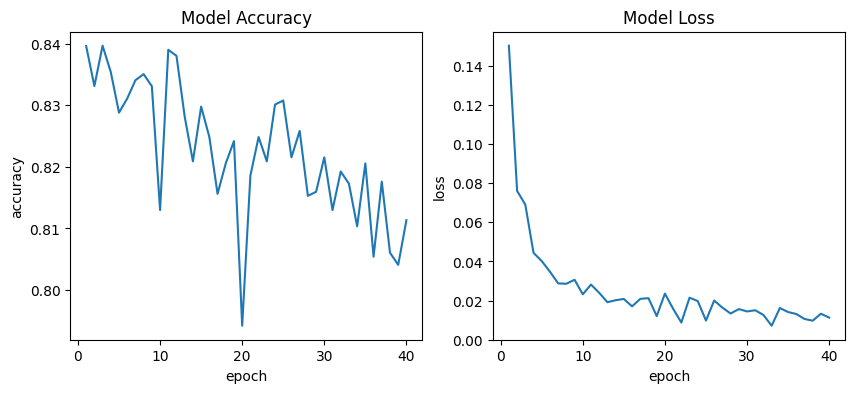

In [ ]:
# def plot_training_hist(history):
'''Function to plot history for accuracy and loss'''

fig, ax = plt.subplots(1, 2, figsize=(10,4))
# first plot
ax[0].plot(epoch_list, accuracy_list)
# ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
# ax[0].legend(['train', 'validation'], loc='best')
# second plot
ax[1].plot(epoch_list, loss_list)
# ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
# ax[1].legend(['train', 'validation'], loc='best')

# plot_training_hist(history)

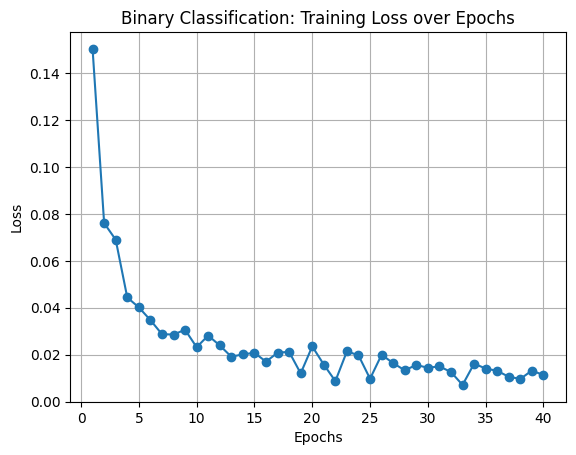

In [ ]:
# Plotting the graph
plt.plot(epoch_list, loss_list, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Classification: Training Loss over Epochs')
plt.grid(True)
plt.show()

## 7. Evaluation


In [ ]:
### Making predictions on test set
def pred_model():
  model.eval()
  total_correct = 0
  total = 0
  y_pred = []
  y_test = []
  for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      y_test.extend(labels.cpu().numpy())
      with torch.inference_mode():
          logits = model(input_ids=input_ids, attention_mask=attention_mask)
      predictions = torch.argmax(logits, dim=1)
      y_pred.extend(predictions.cpu().numpy())
      total_correct += (predictions == labels).sum().item()
      total += predictions.size(0)

  print(f'Test Accuracy: {total_correct / total:.4f}')


In [ ]:
pred_model()

Test Accuracy: 0.8113


In [ ]:
### Function to plot confusion matrix
def plot_confusion_matrix(y_pred, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(y_pred, y_test)

In [ ]:
print('\n*Classification Report:\n', classification_report(y_test, y_pred))

In [ ]:
### Function to predict custom sentiments using trained model
def predict_sentiment(review_text, model, tokenizer, max_length = 512):
    """
    Predicts the sentiment of a given review text.

    Args:
    - review_text (str): The review text to analyze.
    - model (torch.nn.Module): The fine-tuned sentiment analysis model.
    - tokenizer (PreTrainedTokenizer): The tokenizer for encoding the text.
    - max_length (int): The maximum sequence length for the model.

    Returns:
    - sentiment (str): The predicted sentiment label ('negative', 'neutral', 'positive').
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize the input text
    encoding = tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,
          max_length=max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Move tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.inference_mode():
        # Forward pass, get logits
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the highest scoring output
    prediction = torch.argmax(logits, dim=1).item()

    # Map prediction to label
    label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment = label_dict[prediction]

    return sentiment


In [ ]:
# Test
review_1 = "Endured a rough flight with @United. Extremely disappointed with the service and overall experience. Expecting better. "
review_2 = "Absolutely loved the seats on @United - pure comfort and great experience!"

print(predict_sentiment(review_1, model, tokenizer))
print(predict_sentiment(review_2, model, tokenizer))
